# Classifier V1

Idea now: Use pytorch's image encoders and feature extraction

https://pytorch.org/vision/stable/io.html#images

https://pytorch.org/vision/stable/feature_extraction.html



implemented from:
https://medium.com/howtoai/video-classification-with-cnn-rnn-and-pytorch-abe2f9ee031

https://github.com/PacktPublishing/PyTorch-Computer-Vision-Cookbook/blob/master/Chapter10/myutils.py



To do:

*   Run basic classifier using mediapipe and regular data
*   Try to run using VideoMAE output



In [3]:
!pip install torch

In [5]:
import os
import shutil
import pandas as pd
import numpy as np
from numpy import asarray
import cv2 as cv
import re
import math
from subprocess import check_call, PIPE, Popen
import shlex

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torchvision import models
from torch import nn
import torcheval
from torcheval.metrics.functional import multiclass_auprc

## 1 Read Test, Train, and Val set

In [7]:
train = pd.read_pickle("Data/CorpusNGT/train_cutoff247_upperlimit2000.pkl")
test  = pd.read_pickle("Data/CorpusNGT/test_cutoff247_upperlimit2000.pkl")
val   = pd.read_pickle("Data/CorpusNGT/validate_cutoff247_upperlimit2000.pkl")

In [8]:
train

,id,path
3735,GAAN,Data/CorpusNGT/gloss_split_8frames/GAAN\63
17987,PO,Data/CorpusNGT/gloss_split_8frames/PO\2208
3769,GAAN,Data/CorpusNGT/gloss_split_8frames/GAAN\99
832,AL,Data/CorpusNGT/gloss_split_8frames/AL\83
14776,NU-A,Data/CorpusNGT/gloss_split_8frames/NU-A\30
...,...,...
33934,PT,Data/CorpusNGT/gloss_split_8frames/PT\2894
36031,PT,Data/CorpusNGT/gloss_split_8frames/PT\5443
33943,PT,Data/CorpusNGT/gloss_split_8frames/PT\2903
40653,RUIMTE,Data/CorpusNGT/gloss_split_8frames/RUIMTE\54


In [9]:
tr = (train["id"]).unique() ## So there are 157 classes in this dataset of which each have about
va = (val["id"]).unique()
te = (test["id"]).unique()
total = np.concatenate((tr, va, te), axis=0, out=None)
total = np.unique(total)
total = np.sort(total)
print(len(total))
print(len(train))                ## 156.5 instances per class on average.

50
35774


In [10]:
print(total)

['1-A' 'AL' 'BEDOELEN' 'BINNEN' 'BLIJVEN' 'DAN-A' 'DENKEN' 'DOOF-A'
 'DOOF-B' 'DOOF-C' 'GAAN' 'GEBAREN-A' 'GEHANDICAPT-A' 'GOED-A' 'GROEP-A'
 'HEBBEN-A' 'HEE' 'HOREN-A' 'JA-A' 'KIJKEN-A' 'KLAAR-A' 'KOMEN-A'
 'KUNNEN-A' 'LAAT-MAAR' 'MAAR' 'MOETEN-A' 'MOOI-A' 'MOVE-EC-1'
 'MOVE-EC-2R' 'MOVE-EC-4' 'NIET-A' 'NU-A' 'OF' 'ONDERWIJS' 'PLUS' 'PO'
 'POPT' 'PT' 'PV' 'RUIMTE' 'SAMEN-A' 'TAAL-B' 'TOCH-A' 'VROEGER-A'
 'WETEN-A' 'ZEGGEN' 'ZELF' 'ZELFDE-A' 'ZIEN-A' 'ZO-A']


In [11]:
catgs = total
num_classes = len(catgs)
labels_dict = {}
ind = 0
for uc in catgs:
    labels_dict[uc] = ind
    ind+=1

def preprocess_datasubset(split):
    split_labels = split["id"].tolist()
    split_ids = split["path"].tolist()
    print(len(split_ids), len(split_labels))
    return split_ids, split_labels

train_ids, train_labels = preprocess_datasubset(train)
test_ids, test_labels = preprocess_datasubset(test)
val_ids, val_labels = preprocess_datasubset(val)

35774 35774
4473 4473
4471 4471


In [12]:
print(train_ids[90:100])

['Data/CorpusNGT/gloss_split_8frames/HEE\\129', 'Data/CorpusNGT/gloss_split_8frames/POPT\\158', 'Data/CorpusNGT/gloss_split_8frames/PT\\17591', 'Data/CorpusNGT/gloss_split_8frames/GEBAREN-A\\840', 'Data/CorpusNGT/gloss_split_8frames/PO\\4140', 'Data/CorpusNGT/gloss_split_8frames/PT\\116', 'Data/CorpusNGT/gloss_split_8frames/PT\\13324', 'Data/CorpusNGT/gloss_split_8frames/MAAR\\204', 'Data/CorpusNGT/gloss_split_8frames/PT\\14896', 'Data/CorpusNGT/gloss_split_8frames/MAAR\\414']


In [13]:
def cutoff_data(ids, labels):
    listOfCats = os.listdir(ids)

In [14]:
# We've now obtained the paths and labels for all sets of gloss frames that have two or more occurrences of the gloss, and split these into a test and training set

## 2 DEFINE DATASETS AND TRANSFORMS

In [15]:
# Now we have to transform the frames into usable format; tensors

In [16]:
from torch.utils.data import Dataset, DataLoader, Subset
import glob
from PIL import Image
import torch
import numpy as np
import random
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt

np.random.seed(2024)
random.seed(2024)
torch.manual_seed(2024)

In [17]:
# Choose model type, this is just a test. For now we pick the R3D_18 ResNet 18 layer model from pytorch that has been pretrained on the Kinetics dataset

#data_type = "image"
data_type = "keypoint"

#model_type = "R3D_18"
model_type = "Net"
#model_type = "rnn"

data_aug = True

timesteps = 9
if data_type == "image":
    if model_type == "rnn":
        h, w =224, 224
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    else:
        h, w = 270, 270
        mean = [0.43216, 0.394666, 0.37645]
        std = [0.22803, 0.22145, 0.216989]
else:
    h, w = 96, 2 # 75 keypoints x and y so 75 by 2.
    # already normalized by mp so no mean needed

In [18]:
class VideoDataset(Dataset):
    def __init__(self, ids, labels, transform):
        self.transform = transform
        self.ids = ids
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        path2imgs=glob.glob(self.ids[idx]+"/*.jpg")
        path2imgs = path2imgs[:timesteps]
        label = labels_dict[self.labels[idx]]
        frames = []
        for p2i in path2imgs:
            frame = Image.open(p2i)
            frames.append(frame)

        seed = np.random.randint(1e9)
        frames_tr = []
        for frame in frames:
            random.seed(seed)
            np.random.seed(seed)
            frame = self.transform(frame)
            frames_tr.append(frame)
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)
        return frames_tr, label

In [19]:
print(labels_dict)

{'1-A': 0, 'AL': 1, 'BEDOELEN': 2, 'BINNEN': 3, 'BLIJVEN': 4, 'DAN-A': 5, 'DENKEN': 6, 'DOOF-A': 7, 'DOOF-B': 8, 'DOOF-C': 9, 'GAAN': 10, 'GEBAREN-A': 11, 'GEHANDICAPT-A': 12, 'GOED-A': 13, 'GROEP-A': 14, 'HEBBEN-A': 15, 'HEE': 16, 'HOREN-A': 17, 'JA-A': 18, 'KIJKEN-A': 19, 'KLAAR-A': 20, 'KOMEN-A': 21, 'KUNNEN-A': 22, 'LAAT-MAAR': 23, 'MAAR': 24, 'MOETEN-A': 25, 'MOOI-A': 26, 'MOVE-EC-1': 27, 'MOVE-EC-2R': 28, 'MOVE-EC-4': 29, 'NIET-A': 30, 'NU-A': 31, 'OF': 32, 'ONDERWIJS': 33, 'PLUS': 34, 'PO': 35, 'POPT': 36, 'PT': 37, 'PV': 38, 'RUIMTE': 39, 'SAMEN-A': 40, 'TAAL-B': 41, 'TOCH-A': 42, 'VROEGER-A': 43, 'WETEN-A': 44, 'ZEGGEN': 45, 'ZELF': 46, 'ZELFDE-A': 47, 'ZIEN-A': 48, 'ZO-A': 49}


In [20]:
class KeyPointDataset(Dataset):
    def __init__(self, ids, labels, transform):
        self.transform = transform
        self.ids = ids
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        #keypointfile=glob.glob(self.ids[idx]+"/keypoints")
        keypointfile = pd.read_pickle(glob.glob(self.ids[idx]+"/keypoints")[0], compression='infer', storage_options=None)
        keypointfile = keypointfile[["frame","x","y"]]
        label = labels_dict[self.labels[idx]]   ### WAS BUSY HERE TRYING TO FIGURE OUT KEYERROR
        #frames = []
        #for p2i in keypointfile:
        #    frame = np.load(p2i)
        #    frames.append(frame)

## WE NEED TO MAKE SURE ONLY FRAMES 0-7 ARE LOADED SINCE THERE ARE TECHNICALLY 9 NOW.
        
        frames = []
        framelist = list(useful.groupby(by="frame"))
        for frame in framelist:
            frames.append(frame[1].to_numpy())

        seed = np.random.randint(1e9)
        frames_tr = []
        for frame in frames:
            random.seed(seed)
            np.random.seed(seed)
            frames_tr.append(torch.from_numpy(frame))
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)
        return frames_tr, label

In [21]:
## Test
if data_type == "keypoint":

    keypointfile = pd.read_pickle("Data/CorpusNGT/gloss_split_8frames/0-A/0/keypoints", compression='infer', storage_options=None)
    useful = keypointfile[["frame","x","y"]]
    framelist = list(useful.groupby(by="frame"))
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(framelist[6])
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(keypointfile)

(6,      frame         x         y
576      6  0.445450  0.372057
577      6  0.421211  0.444590
578      6  0.428399  0.402208
579      6  0.415481  0.304097
580      6  0.430593  0.304195
581      6  0.449607  0.319474
582      6  0.411781  0.415773
583      6  0.413046  0.299734
584      6  0.413770  0.416578
585      6  0.423874  0.408950
586      6  0.419154  0.434224
587      6  0.414794  0.425203
588      6  0.430743  0.298510
589      6  0.451404  0.310685
590      6  0.427784  0.325514
591      6  0.410360  0.420586
592      6  0.435652  0.327927
593      6  0.432601  0.323709
594      6  0.424456  0.320279
595      6  0.421302  0.321324
596      6  0.438700  0.327630
597      6  0.411079  0.433798
598      6  0.419629  0.318561
599      6  0.439916  0.406357
600      6  0.503367  0.335942
601      6  0.491464  0.324682
602      6  0.469017  0.325132
603      6  0.445731  0.428338
604      6  0.508453  0.333726
605      6  0.443718  0.427612
606      6  0.439788  0.414801
607 

In [22]:
# define helper functions

def transform_frames(frames, model_type="rnn"):
    # Only necessary when working with frames not with the mediapipe data
    if model_type == "rnn":
        h, w = 270, 270
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    else:
        h, w = 135, 135
        mean = [0.43216, 0.394666, 0.37645]
        std = [0.22803, 0.22145, 0.216989]

    test_transformer = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)])

    frames_tr = []
    for frame in frames:
        frame = Image.fromarray(frame)
        frame_tr = test_transformer(frame)
        frames_tr.append(frame_tr)
    imgs_tensor = torch.stack(frames_tr)

    if model_type != "rnn":
        imgs_tensor = torch.transpose(imgs_tensor, 1, 0)
    imgs_tensor = imgs_tensor.unsqueeze(0)
    return imgs_tensor

def transform_keypoint_frames(frames, model_type="rnn"):
    h, w = 96, 2
    # already normalized by mp

    test_transformer = transforms.Compose([
                torch.from_numpy()]
        )

    frames_tr = []
    for frame in frames:
        frame = frame
        frame_tr = test_transformer(frame)
        frames_tr.append(frame_tr)
    imgs_tensor = torch.stack(frames_tr)

    return imgs_tensor

def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)
    return x

TRAIN

In [23]:
mean = [0.43216, 0.394666, 0.37645]
std = [0.22803, 0.22145, 0.216989]

train_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])

train_transformer_keypoints = transforms.Compose([
            transforms.ToTensor()
            ])

if data_type == "image":
    train_ds = VideoDataset(ids= train_ids, labels= train_labels, transform= train_transformer)
    print(len(train_ds))
elif data_type == "keypoint":
    train_ds = KeyPointDataset(ids= train_ids, labels= train_labels, transform= train_transformer_keypoints)
    print(len(train_ds))
else:
    print("whaaat")

print(train_ds)

35774


In [24]:
# inspect
imgs, label = train_ds[10]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

(torch.Size([9, 96, 3]),
 35,
 tensor(0., dtype=torch.float64),
 tensor(8., dtype=torch.float64))

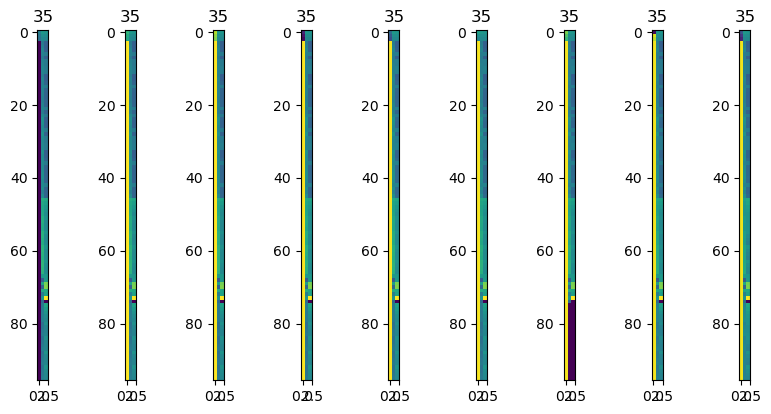

In [25]:
%matplotlib inline

## For image condition, not keypoints
if data_type == "keypoint":
    plt.figure(figsize=(10,10))
    for ii,img in enumerate(imgs[::1]):
        plt.subplot(2,9,ii+1)
        plt.imshow(denormalize(img, mean, std))
        plt.title(label)

TEST and VAL

In [26]:
test_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])

test_transformer_keypoints = transforms.Compose([
            transforms.ToTensor()
            ])

if data_type == "image":
    test_ds = VideoDataset(ids= test_ids, labels= test_labels, transform= test_transformer)
    print(len(test_ds))
    val_ds = VideoDataset(ids= val_ids, labels= val_labels, transform= test_transformer)
    print(len(val_ds))
elif data_type == "keypoint":
    test_ds = KeyPointDataset(ids= test_ids, labels= test_labels, transform= test_transformer_keypoints)
    print(len(test_ds))
    val_ds = KeyPointDataset(ids= val_ids, labels= val_labels, transform= test_transformer_keypoints)
    print(len(val_ds))
else:
    print("whaat")

4473
4471


In [27]:
imgs, label = test_ds[5]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

(torch.Size([9, 96, 3]),
 32,
 tensor(0., dtype=torch.float64),
 tensor(8., dtype=torch.float64))

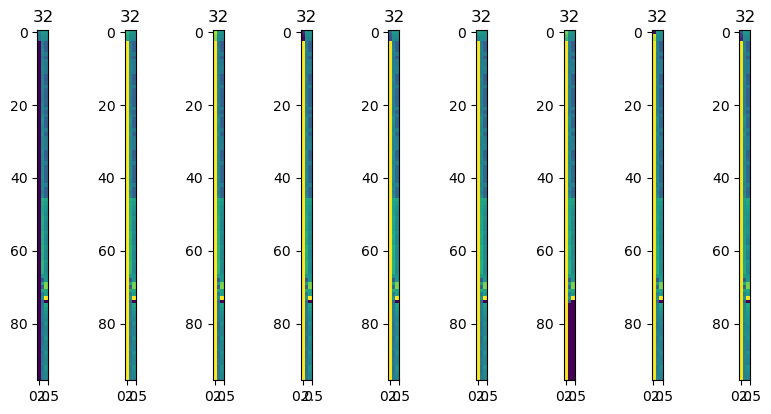

In [28]:
if data_type == "keypoint":
    plt.figure(figsize=(10,10))
    for ii,img in enumerate(imgs[::1]):
        plt.subplot(2,9,ii+1)
        plt.imshow(denormalize(img, mean, std))
        plt.title(label)

## 3 DEFINE DATALOADER

We define the custom dataloader for our model; batch and stack the images etc

In [29]:
def collate_fn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    if data_type == "image":
        imgs_tensor = torch.transpose(imgs_tensor, 2, 1)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor

def collate_fn_rnn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor


batch_size = 4
if model_type == "rnn":
    train_dl = DataLoader(train_ds, batch_size= batch_size,
                          shuffle=True, collate_fn= collate_fn_rnn)
    test_dl = DataLoader(test_ds, batch_size= batch_size,
                         shuffle=False, collate_fn= collate_fn_rnn)
    val_dl = DataLoader(val_ds, batch_size= batch_size,
                         shuffle=False, collate_fn= collate_fn_rnn)
elif model_type == "Net":
    train_dl = DataLoader(train_ds, batch_size= batch_size,
                          shuffle=True, collate_fn= collate_fn)
    test_dl = DataLoader(test_ds, batch_size= batch_size,
                         shuffle=False, collate_fn= collate_fn)
    val_dl = DataLoader(val_ds, batch_size= batch_size,
                         shuffle=False, collate_fn= collate_fn)
else:
    print("whaaat")

In [30]:
for xb,yb in train_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([4, 9, 96, 3]) torch.Size([4])


In [31]:
for xb,yb in test_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([4, 9, 96, 3]) torch.Size([4])


In [32]:
for xb,yb in val_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([4, 9, 96, 3]) torch.Size([4])


## 4 DEFINE MODEL

In [33]:
## Here a we create out own network

import torchvision
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    #Initial testing model
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=timesteps, out_channels=64, kernel_size=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(48 * 8 * 8, 480)
        self.fc2 = nn.Linear(480, 120)
        self.fc3 = nn.Linear(120, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



class SignAdapter(nn.Module):
    ### Unfinished test
    def __init__(self):
        super().__init__()
        #self.keypointlinear = nn.Linear(48 * 8 * 8, 480)
        self.linearlayer1 = nn.Linear(2, 2048)
        self.linearlayer2 = nn.Linear(2048, num_classes)
        self.CNN = nn.Conv2d(in_channels=timesteps, out_channels=8, kernel_size=1)

    def forward(self, x):
        ## In the baseline architecture there is one more linear layer in front, a seperate one for the spatial features and for the motion features.
        ## For now we just have a linear layer for the keypoints, since this linear layer is meant to turn the inputs into the same size.
        #x = self.keypointlinear(x)
        x = self.CNN(x)

        # This section is essentially an MLP
        x = self.linearlayer1(x)
        x = F.relu(x)
        x = self.linearlayer2(x)
        return x

In [34]:
## CHANGE MODEL ARCH HERE

if model_type == "rnn":
    params_model={
        "num_classes": num_classes,
        "dr_rate": 0.1,
        "pretrained" : True,
        "rnn_num_layers": 1,
        "rnn_hidden_size": 100,}
    model = Resnt18Rnn(params_model)
elif model_type == "Net":
    if data_type == "keypoint":
        model = Net()
    else:
        print("Net model cannot be used for data type other than keypoint")
elif model_type == "R3D_18":
    if data_type == "image":
        model = models.video.r3d_18(weights='KINETICS400_V1', progress=False)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
    else:
        print("R3D_18 model only works for image data type")
else:
    print("No such model exists")

In [35]:
with torch.no_grad():
    if model_type=="rnn":
        x = torch.zeros(batch_size, timesteps, 3, h, w)
    else:
        if data_type == "keypoint":
            x = torch.zeros(batch_size, timesteps, h, w)
        else:
            x = torch.zeros(batch_size, 3, timesteps, h, w)
    y= model(x)
    print(y.shape)
    print(x.shape)

torch.Size([4, 50])
torch.Size([4, 9, 96, 2])


In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [37]:
model

Net(
  (conv1): Conv2d(9, 64, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3072, out_features=480, bias=True)
  (fc2): Linear(in_features=480, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=50, bias=True)
)

## 5 TRAIN MODEL

In [38]:
modelweights = "Models/Net_Test_50classes_weights1"
torch.save(model.state_dict(), modelweights)
num_epochs = 40
modelname = "Net"

In [39]:
num_classes

50

In [40]:
import copy
import tqdm

def metrics_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    TruePositives = pred.eq(target.view_as(pred)).sum().item()
    return TruePositives

def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    with torch.no_grad():
        TruePositives = metrics_batch(output,target) # returns True Positives
        ## From here is new
        Avg_Precision = multiclass_auprc(output, target, average='macro').detach().item()
        Avg_Precision_per_class = multiclass_auprc(output, target, average='none')
        ##
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), TruePositives, Avg_Precision, Avg_Precision_per_class

def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss=0.0
    accuracy_total=0.0
    counter=0
    len_data = len(dataset_dl.dataset)
    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb.float())
        loss_b, TruePositives, Avg_Precision, Avg_Precision_per_class = loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        
        # GET ACCURACY
        if TruePositives is not None:
            counter += 1
            accuracy_total += TruePositives

        if sanity_check is True:
            break

    loss=running_loss/float(len_data)
    avg_accuracy = accuracy_total/counter
    avg_precision = Avg_Precision
    return loss, avg_accuracy, avg_precision, Avg_Precision_per_class

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history={
        "train": [],
        "val": [],
    }

    metric_history={
        "train_avg_accuracy": [],
        "val_avg_accuracy": [],
        "train_avg_precision": [],
        "val_avg_precision": [],
        "train_avg_precision_per_class": [],
        "val_avg_precision_per_class": [],
    }
    

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')

    for epoch in tqdm.tqdm(range(num_epochs)):
        current_lr=get_lr(opt)
        #print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        model.train()
        train_loss, train_avg_accuracy, train_avg_precision, train_avg_precision_per_class =loss_epoch(model,loss_func,train_dl,sanity_check,opt)
        loss_history["train"].append(train_loss)
        metric_history["train_avg_accuracy"].append(train_avg_accuracy)
        metric_history["train_avg_precision"].append(train_avg_precision)
        metric_history["train_avg_precision_per_class"].append(train_avg_precision_per_class)
        model.eval()
        with torch.no_grad():
            val_loss, val_avg_accuracy, val_avg_precision, val_avg_precision_per_class = loss_epoch(model,loss_func,val_dl,sanity_check)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            #print("Copied best model weights")

        loss_history["val"].append(val_loss)
        metric_history["val_avg_accuracy"].append(val_avg_accuracy)
        metric_history["val_avg_precision"].append(val_avg_precision)
        metric_history["val_avg_precision_per_class"].append(val_avg_precision_per_class)

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            #print("Loading best model weights")
            model.load_state_dict(best_model_wts)


        #print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
        #print("-"*10)
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [41]:
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import tqdm

#=lr_scheduler = CosineAnnealingLR(opt, T_max=40)     # maximum amount of iterations on the lr
#=lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5, verbose=True)    # patientce is 5, so after 5 epochs of no improvement learning rate is lr*factor, so halved
#loss_func_ctc = torch.nn.CTCLoss(zero_infinity=True, reduction='sum')

loss_func = torch.nn.CrossEntropyLoss(reduction='sum', label_smoothing=0.1)
opt = optim.Adam(model.parameters(), lr=1e-3)        # original lr=3e-5 in baseline paper lr=1e-3. Baseline also uses adam with batch size of 8 and weight decay of 1e-3.
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5, verbose=True)     # maximum amount of iterations on the lr
os.makedirs("Thesis/Models", exist_ok=True)

params_train={
    "num_epochs": num_epochs,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": modelweights+".pt",
    }

C:\Users\novan\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [62]:
model,loss_hist,metric_hist = train_val(model,params_train)

100%|██████████| 40/40 [28:20:24<00:00, 2550.62s/it]     


In [64]:
def plot_loss(loss_hist, metric_hist):
    num_epochs= len(loss_hist["train"])

    plt.title("Train-Val Loss")
    plt.plot(range(1,num_epochs+1), loss_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1), loss_hist["val"],label="val")
    plt.ylabel("Loss")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.savefig("Models/"+modelname+' Train-Val Loss.png')
    plt.show()

    plt.title("Train-Val Average Accuracy")
    plt.plot(range(1,num_epochs+1), metric_hist["train_avg_accuracy"],label="train")
    plt.plot(range(1,num_epochs+1), metric_hist["val_avg_accuracy"],label="val")
    plt.ylabel("Accuracy")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.savefig("Models/"+modelname+' Train-Val Average Accuracy.png')
    plt.show()

    plt.title("Train-Val Average Precision")
    plt.plot(range(1,num_epochs+1), metric_hist["train_avg_precision"],label="train")
    plt.plot(range(1,num_epochs+1), metric_hist["val_avg_precision"],label="val")
    plt.ylabel("Precision")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.savefig("Models/"+modelname+' Train-Val Average Precision.png')
    plt.show()

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

def plot_avg_p_per_class(final_item_train, final_item_val):
    plt.title("Train-Val Precision Per Class")
    counts_a, bins_a = np.histogram(final_item_train, bins=num_classes, range=(0,num_classes), density=None, weights=None)
    counts_b, bins_b = np.histogram(final_item_val, bins=num_classes, range=(0,num_classes), density=None, weights=None)
    counts_a = np.positive(final_item_train)
    counts_b = np.positive(final_item_val)
    plt.bar(catgs, counts_a, label="train")
    plt.bar(catgs, counts_b, label="val")
    plt.rcParams['figure.figsize'] = [12, 4]
    plt.xticks(rotation=90, fontsize=10)
    plt.ylabel("Precision per class")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.savefig("Models/"+modelname+' Train-Val Final Precision Per Class.png')
    plt.show()

#def plot_occurrences_per_class(train, test, catgs)
#    plt.title("Occurrences in Data Per Class")
#    train_counts = 
#    

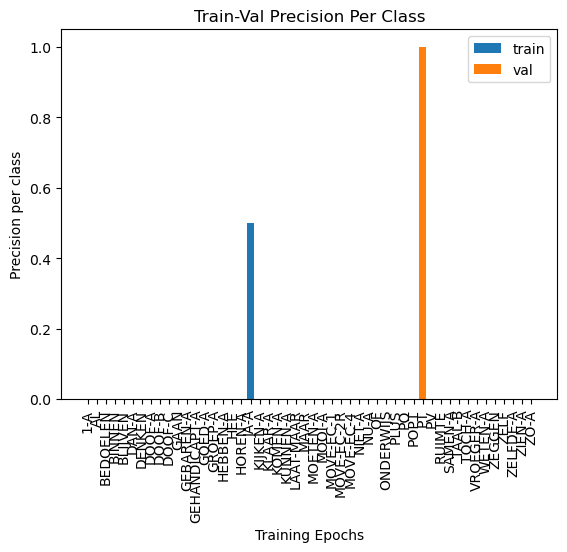

In [65]:
plot_avg_p_per_class(metric_hist["train_avg_precision_per_class"][len(metric_hist["train_avg_precision_per_class"]) - 1].tolist(),
                    metric_hist["val_avg_precision_per_class"][len(metric_hist["val_avg_precision_per_class"]) - 1].tolist())

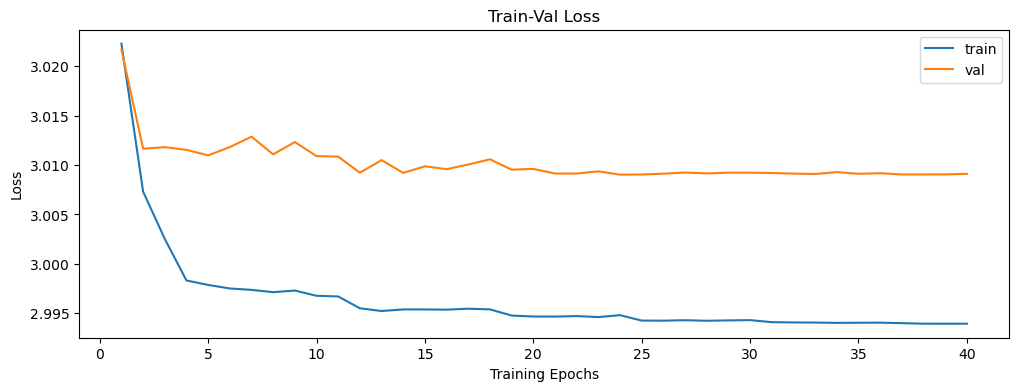

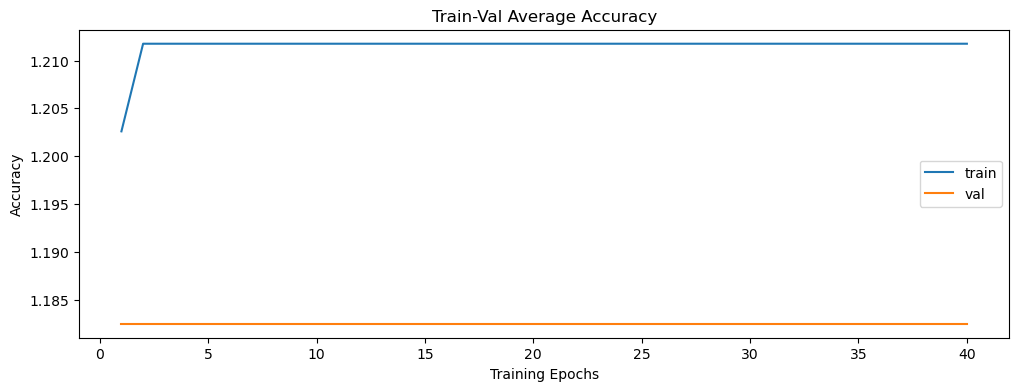

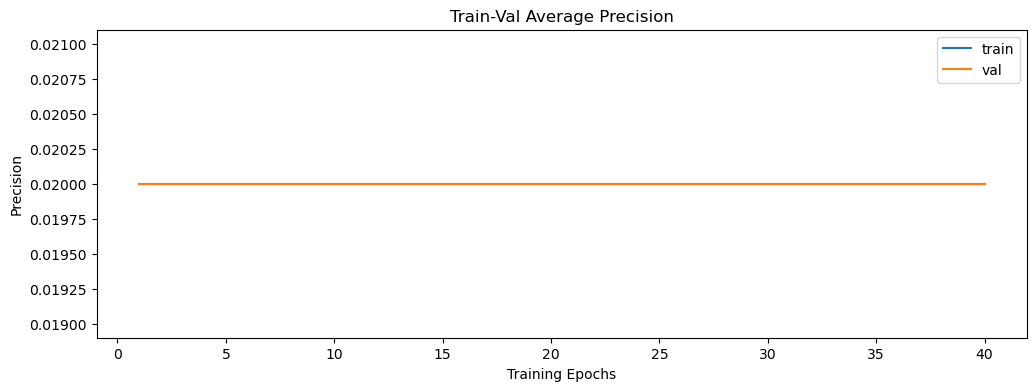

In [66]:
plot_loss(loss_hist, metric_hist)

----------------------

## 6 TEST MODEL

Code needs to be changed to reflect the new keypoints data type

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load(modelweights))
model.to(device);

model.eval()

Net(
  (conv1): Conv2d(9, 64, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3072, out_features=480, bias=True)
  (fc2): Linear(in_features=480, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=50, bias=True)
)

In [43]:
test_ds
imgs, label = test_ds[5]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

(torch.Size([9, 96, 3]),
 32,
 tensor(0., dtype=torch.float64),
 tensor(8., dtype=torch.float64))

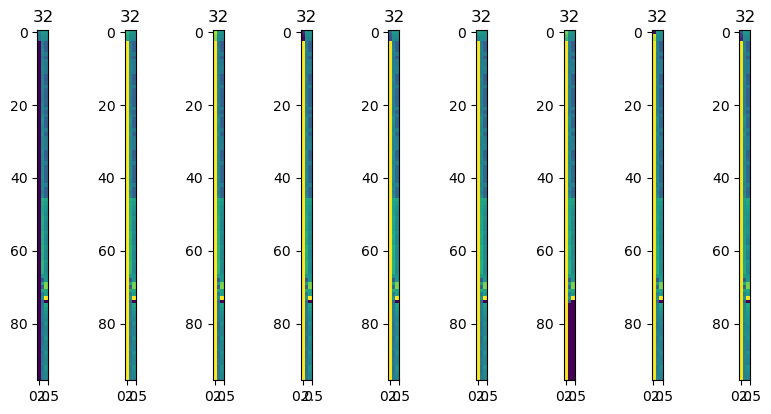

In [44]:
plt.figure(figsize=(10,10))
for ii,img in enumerate(imgs[::1]):
    plt.subplot(2,9,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(label)

In [45]:
def Accuracy(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    TruePositives = pred.eq(target.view_as(pred)).sum().item()
    return TruePositives

def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    with torch.no_grad():
        TruePositives = Accuracy(output,target)
        Avg_Precision = multiclass_auprc(output, target, average='macro').detach().item()
        Avg_Precision_per_class = multiclass_auprc(output, target, average='none')
    return loss.item(), TruePositives, Avg_Precision, Avg_Precision_per_class

def calculate_performance(model, test_dl, sanity_check=False):
    running_loss=0.0
    accuracy_total=0.0
    counter=0
    len_data = len(test_dl.dataset)
    for xb, yb in test_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb.float())
        loss_b, TruePositives, Avg_Precision, Avg_Precision_per_class = loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b

        # GET ACCURACY
        if TruePositives is not None:
            counter += 1
            accuracy_total += TruePositives

        if sanity_check is True:
            break

    loss=running_loss/float(len_data)
    avg_accuracy = accuracy_total/counter
    return loss, avg_accuracy, Avg_Precision, Avg_Precision_per_class

def evaluate_model(model, test_dl, sanity_check=False):
    with torch.no_grad():
        test_loss, test_metric, test_precision, test_precision_perclass = calculate_performance(model,test_dl,sanity_check)
    return test_loss, test_metric, test_precision, test_precision_perclass

In [46]:
test_loss, test_accuracy, test_precision, test_precision_perclass = evaluate_model(model, test_dl, sanity_check=False)  #Sanity check true makes model stop after one iteration
train_loss, train_accuracy, train_precision, train_precision_perclass = evaluate_model(model, train_dl, sanity_check=False)
val_loss, val_accuracy, val_precision, val_precision_perclass = evaluate_model(model, val_dl, sanity_check=False)

print("test loss: " +str(test_loss))
print("test accuracy: " +str(test_accuracy))
print("test precision: " +str(test_precision))
print("test precision per class: " +str(test_precision_perclass))

test loss: 3.91313409965203
test accuracy: 0.022341376228775692
test precision: 0.019999999552965164
test precision per class: tensor([-0., -0., -0., -0., -0., -0., -0., 1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.])


In [48]:
def writeStats(filename,   test_loss,  test_accuracy,  test_precision,  test_precision_p_c,
                           train_loss, train_accuracy, train_precision, train_precision_perclass,
                           val_loss,   val_accuracy,   val_precision,   val_precision_perclass):
    with open(modelweights + "_" + filename, 'w') as f:
        f.write("TEST" + "\n")
        f.write("Loss: \t\t\t" + str(test_loss) + "\n")
        f.write("Avg Accuracy: \t\t\t" + str(test_accuracy) + "\n")
        f.write("Avg Precision: \t\t\t" + str(test_precision) + "\n")
        f.write("Avg Precision per class: \t\t" + str(test_precision_p_c) + "\n")
        f.write("\n TRAIN \n")
        f.write("Loss: \t\t\t" + str(train_loss) + "\n")
        f.write("Avg Accuracy: \t\t\t" + str(train_accuracy) + "\n")
        f.write("Avg Precision: \t\t\t" + str(train_precision) + "\n")
        f.write("Avg precision per class: \t\t" + str(train_precision_perclass) + "\n")
        f.write("\n VAL \n")
        f.write("Loss: \t\t\t" + str(val_loss) + "\n")
        f.write("Avg Accuracy: \t\t\t" + str(val_accuracy) + "\n")
        f.write("Avg Precision: \t\t\t" + str(val_precision) + "\n")
        f.write("Avg precision per class: \t\t" + str(val_precision_perclass) + "\n")

In [50]:
writeStats("testResults",   test_loss,  test_accuracy,  test_precision,  test_precision_perclass,
                           train_loss, train_accuracy, train_precision, train_precision_perclass,
                           val_loss,   val_accuracy,   val_precision,   val_precision_perclass)